In [1]:
import os
import re
import math
import gzip
import spacy
import urllib
import string
import pickle
import tarfile
import requests
import itertools
import collections
import pandas as pd
import pandas as pd
import numpy as np
from collections import Counter
from utils.plot_processing import extract_word_frequency
import statsmodels.formula.api as smf
from wordcloud import WordCloud
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve

%matplotlib inline

In [2]:
cmu_path = "data/MovieSummaries/"
corenlp_path = "data/CoreNLP/"
summary_raw_path = corenlp_path + "corenlp_plot_summaries/"
summary_path = corenlp_path + "corenlp_plot_summaries_xml/"
movies_path = cmu_path + "movie.metadata.tsv"
characters_path = cmu_path + "character.metadata.tsv"
plot_path = cmu_path + "plot_summaries.txt"
gender_dict_path = "data/gender_dict.pkl"
gender_dict_with_time_path = "data/gender_dict_with_time.pkl"
gender_dict_with_genre_path = "data/gender_dict_with_genre.pkl"

In [3]:
if not os.path.exists(movies_path):
    movie_url = "http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz"
    tar_file = tarfile.open(fileobj=urllib.request.urlopen(movie_url), mode="r:gz")
    tar_file.extractall(path=movies_path)
    tar_file.close()

In [4]:
if not os.path.exists(corenlp_path):
    corenlp_url = "http://www.cs.cmu.edu/~ark/personas/data/corenlp_plot_summaries.tar"
    tar_file = tarfile.open(fileobj=urllib.request.urlopen(corenlp_url), mode="r|")
    tar_file.extractall(path=corenlp_path)

    os.mkdir(summary_path)
    for filename in os.listdir(summary_raw_path):
        f = os.path.join(summary_raw_path, filename)
        if os.path.isfile(f):
            with gzip.open(f, "rb") as f_in:
                gz_file = os.path.join(summary_path, filename)
                with open(gz_file[:-3], "wb") as f_out:
                    f_out.write(f_in.read())
    tar_file.close()

In [5]:
movies_column_names = [
    "wikipedia_id",
    "freebase_id",
    "name",
    "release_date",
    "box_office_revenue",
    "runtime",
    "languages",
    "countries",
    "genres",
]

characters_column_names = [
    "wikipedia_id",
    "freebase_id",
    "release_date",
    "character_name",
    "actor_dob",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age",
    "freebase_character_map",
    "freebase_character_id",
    "freebase_actor_id",
]

plot_column_names = ["wikipedia_id", "summary"]

movies = pd.read_csv(movies_path, sep="\t", header=None, names=movies_column_names)
characters = pd.read_csv(
    characters_path, sep="\t", header=None, names=characters_column_names
)
plots = pd.read_csv(plot_path, sep="\t", header=None, names=plot_column_names)

In [6]:
movies = movies.dropna(subset=['release_date'])

print("{} movies left (81741 before).".format(len(movies)))
movies.head()

74839 movies left (81741 before).


,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [7]:
def extract_year(x):
    return str(x)[:4]


movies.release_date = movies.release_date.apply(extract_year)
characters.release_date = characters.release_date.apply(extract_year)

In [8]:
movies[movies.release_date == "1010"]

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
62836,29666067,/m/0fphzrf,Hunting Season,1010,12160978.0,140.0,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc...","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My..."


In [9]:
movies.release_date = movies.release_date.apply(lambda x: "2010" if x == "1010" else x)
characters.release_date = characters.release_date.apply(
    lambda x: "2010" if x == "1010" else x
)

In [10]:
get_dict_keys = (
    lambda x: np.nan
    if x == {}
    else [re.sub(r"\x20[Ll]anguage", "", w) for w in re.findall(r'"(.*?)"', x)[1::2]]
)
movies.countries = movies.countries.apply(get_dict_keys)
movies.languages = movies.languages.apply(get_dict_keys)
movies.genres = movies.genres.apply(get_dict_keys)

In [11]:
movies_plots = pd.merge(movies, plots, on="wikipedia_id", how="inner")[
    ["wikipedia_id", "release_date", "languages", "countries", "genres", "summary"]
]
movies_plots.head()

,wikipedia_id,release_date,languages,countries,genres,summary
0,975900,2001,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,9363483,1987,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
2,261236,1983,[German],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra..."
3,18998739,2002,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
4,6631279,1997,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."


In [12]:
characters_filtered = characters.dropna(subset=["character_name", "actor_gender"])
characters_filtered.head()

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [13]:
temp_df = movies_plots[movies_plots.wikipedia_id.isin(characters_filtered.wikipedia_id)]

In [14]:
index = []
name_gender = []
count_gender = {"M": 0, "F": 0}
for i in range(len(temp_df)):
    temp_name_gender = {}
    flag = 0
    filtered = characters_filtered[
        characters_filtered.wikipedia_id == temp_df.iloc[i].wikipedia_id
    ]
    for word, gender in zip(
        filtered.character_name.apply(str.lower), filtered.actor_gender
    ):
        if (
            word in temp_df.iloc[i].summary.lower()
        ):  # only consider full match. i.e. full character name matches with the plot summary.
            if (
                flag == 0
            ):  # if there's one full match in the plot summary, we keep this movie.
                index.append(i)
                flag = 1
            temp_name_gender[word] = gender
            count_gender[gender] += 1
    if flag == 1:
        name_gender.append(temp_name_gender)

assert len(name_gender) == len(index)

In [15]:
movies_plots_filtered = temp_df.iloc[index].copy()
movies_plots_filtered.loc[:, "character_names"] = name_gender
movies_plots_filtered = movies_plots_filtered.reset_index(drop=True)
movies_plots_filtered.head()

,wikipedia_id,release_date,languages,countries,genres,summary,character_names
0,975900,2001,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",{'desolation williams': 'M'}
1,18998739,2002,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns...",{'morgana': 'F'}
2,6631279,1997,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a...","{'rebecca': 'F', 'nina': 'F'}"
3,171005,1989,[English],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,{'henry v': 'M'}
4,77856,1964,[English],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",The film opens with Mary Poppins perched in a...,"{'george banks': 'M', 'bert': 'M', 'mary poppi..."


In [16]:
# for each gender, compute word frequency dictionary on all words/nouns/verbs/adjectives.
gender_dict = {
    "M": {"all": {}, "noun": {}, "verb": {}, "adj": {}},
    "F": {"all": {}, "noun": {}, "verb": {}, "adj": {}},
}

# keep these POSs and map POS to verbs/nouns/adjectives
pos_mapping = {
    "JJ": "adj", "JJR": "adj", "JJS": "adj",                                                    # adjectives
    "NN": "noun", "NNS": "noun", "NNP": "noun", "NNPS": "noun",                                 # nouns
    "VB": "verb", "VBD": "verb", "VBG": "verb", "VBN": "verb", "VBP": "verb", "VBZ": "verb",    # verbs
}

window_size = 2  # search two words of {n., adj., v.} before first name and after last name if possible.

In [17]:
if not os.path.exists(gender_dict_path):
    # compute the word frequency of different word types
    gender_dict = extract_word_frequency(movies_plots_filtered, gender_dict, pos_mapping, summary_path, window_size=window_size)

    # create a binary pickle file 
    with open(gender_dict_path, "wb") as f:
        # write the python object (dict) to pickle file
        pickle.dump(gender_dict, f)

else:
    with open(gender_dict_path, "rb") as f:
        gender_dict = pickle.load(f)

## Gender stereotype analysis on movie plot summaries

Now we want to know whether gender stereotypes exist in movie plot summaries. We define gender stereotypes as the distribution difference of the words describing male and female characters in the movie plot summaries. We consider relevant words around male characters and female characters. We implement this by searching plot summaries containing character names in the `character` dataframe. Then we identify relevant words as first or last two words of noun, verb, or adjective from the character name within one sentence. We extract relevant words around these names by gender and count log frequency of words related to different genders. Finally we analyze top 15 frequent words for different genders.

### Stopwords Removal

There are so many stopwords like "be", "have", etc. We want to remove them.

In [18]:
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
spacy_stopwords.add("s")

In [19]:
for gender, inner_dict in gender_dict.items():
    for word_type, freq_dict in inner_dict.items():
        for stopword in spacy_stopwords:
                freq_dict.pop(stopword.lower(), None)

### Overall Analysis

#### Qualitative

We first analyze the overall distribution of relevant words of male and female characters. Then we compare log frequencies of different POS of the words (noun, verb, adjective) between men and women.

We compare the frequency difference. (M-F), 正值最大: male-distinguishable; 负值最大: female-distinguishable.

In [20]:
diff_dict = {}
male_dict = {}
female_dict = {}

for idx, word_type in enumerate(["all", "noun", "verb", "adj"]):
    male_words = pd.DataFrame.from_dict(
        gender_dict["M"][word_type], orient="index", columns=["count"]
    ).sort_values(by=["count"])
    male_dict[word_type] = male_words

    female_words = pd.DataFrame.from_dict(
        gender_dict["F"][word_type], orient="index", columns=["count"]
    ).sort_values(by=["count"])
    female_dict[word_type] = female_words

    diff_words = pd.concat([male_words, female_words], axis=1).dropna()
    diff_words.columns = ["count_m", "count_f"]
    diff_words.fillna(0, inplace=True)
    diff_words["freq_m"] = diff_words["count_m"] / diff_words["count_m"].sum()
    diff_words["freq_f"] = diff_words["count_f"] / diff_words["count_f"].sum()
    diff_words["freq_diff"] = diff_words.freq_m - diff_words.freq_f
    diff_dict[word_type] = diff_words

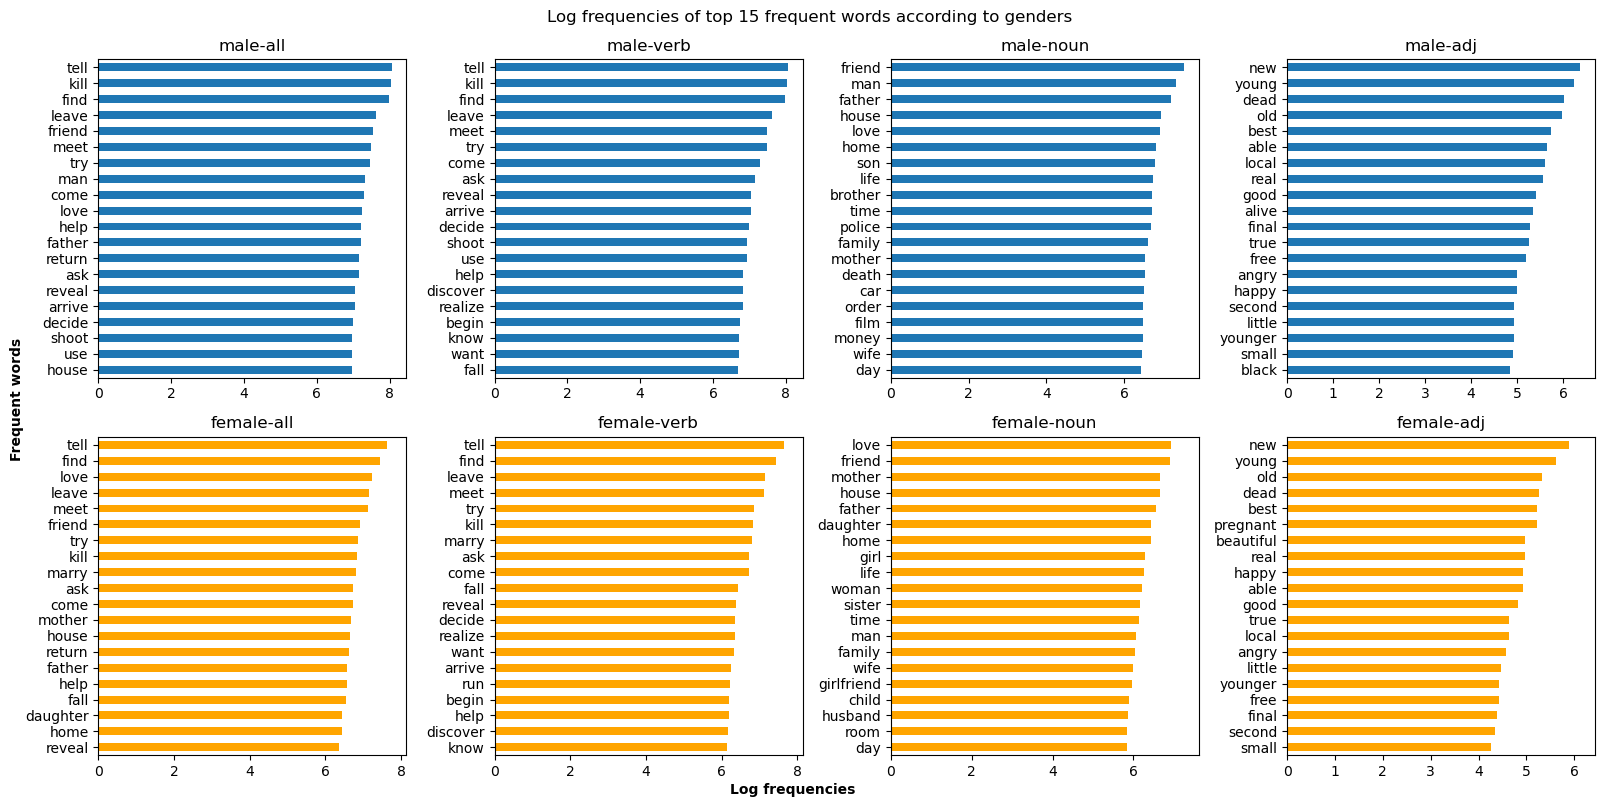

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()
fig.suptitle(
    "Log frequencies of top 15 frequent words according to genders"
)

for idx, word_type in enumerate(["all", "verb", "noun", "adj"]):

    ax = np.log(male_dict[word_type]["count"][-20:]).plot.barh(
        ax=axes[idx], legend=False, title="male-{}".format(word_type)
    )
    ax = np.log(female_dict[word_type]["count"][-20:]).plot.barh(
        ax=axes[idx + 4],
        color="orange",
        legend=False,
        title="female-{}".format(word_type),
    )
    ax.set_xlim(0, max(np.log(male_dict[word_type]["count"][-20:]).max(), np.log(male_dict[word_type]["count"][-20:]).max())*1.01)

fig.text(0.45, 0, "Log frequencies", weight="bold")
fig.text(0, 0.42, "Frequent words", rotation=90, weight="bold")
plt.tight_layout()
plt.show()

这个表的效果并不好, 因为有太多词男女通用了, 而且很高频. 真正要研究不一样的. 根据 p2 feedback 选择求 frequency difference. 然后排序最正的 (male bias) 和最负的 (female bias).

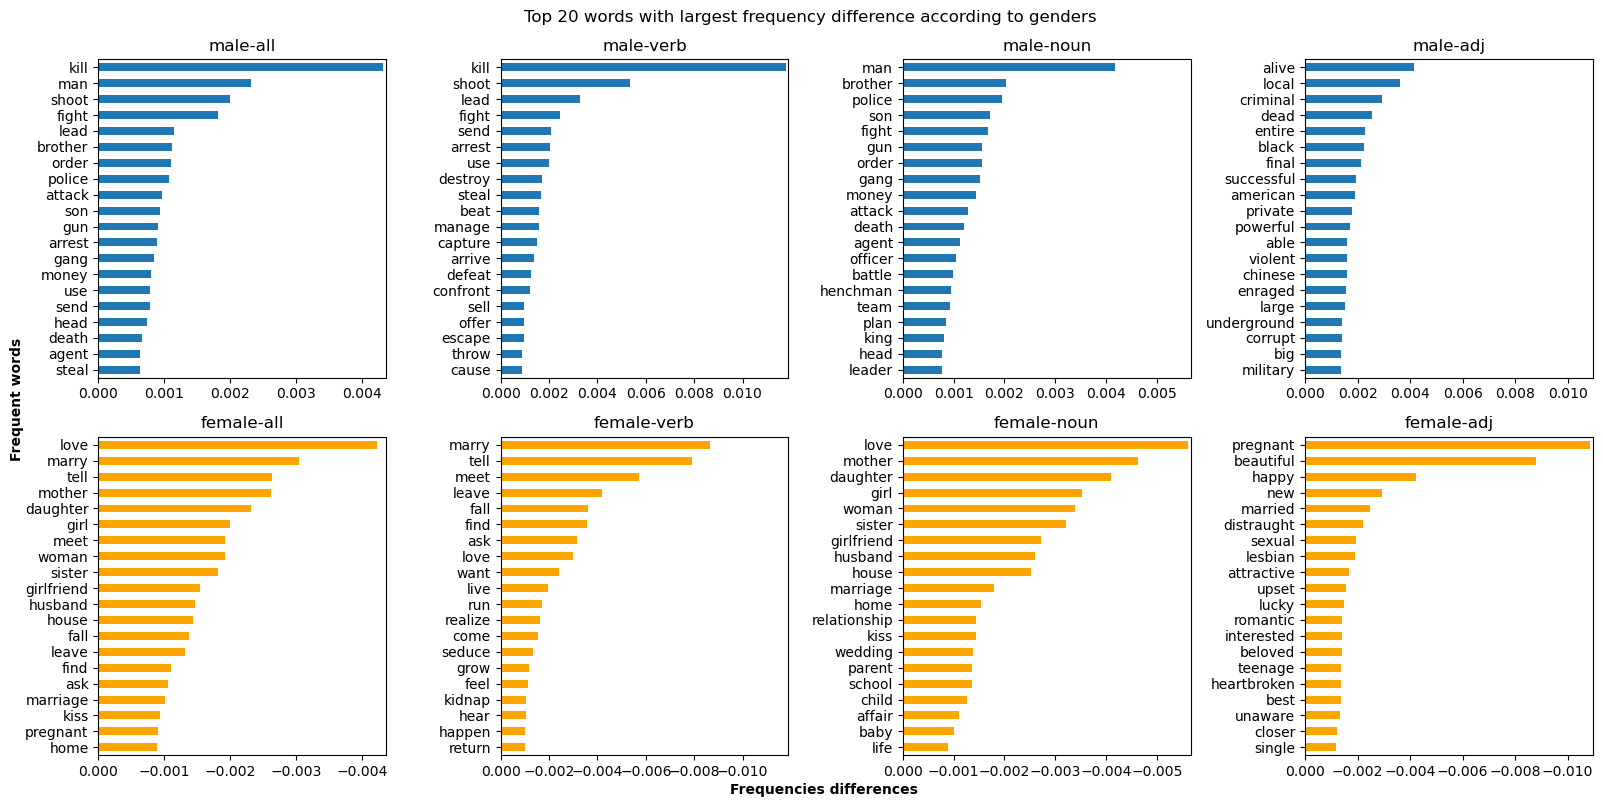

In [22]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()
fig.suptitle(
    "Top 20 words with largest frequency difference according to genders"
)

for idx, word_type in enumerate(["all", "verb", "noun", "adj"]):
    male_words = diff_dict[word_type].freq_diff.sort_values()[-20:]
    female_words = diff_dict[word_type].freq_diff.sort_values(ascending=False)[-20:]
    ax1 = male_words.plot.barh(
        ax=axes[idx], legend=False, title="male-{}".format(word_type)
    )
    ax1.set_xlim(0.000, max(abs(male_words).max(), abs(female_words).max())*1.01)
    ax2 = female_words.plot.barh(
        ax=axes[idx + 4],
        color="orange",
        legend=False,
        title="female-{}".format(word_type),
    )
    ax2.set_xlim(0.000, -max(abs(male_words).max(), abs(female_words).max())*1.01)

fig.text(0.45, 0, "Frequencies differences", weight="bold")
fig.text(0, 0.42, "Frequent words", rotation=90, weight="bold")
plt.tight_layout()
plt.show()

**Analysis**: TODO

#### Quantitative

只研究 verb 和 adjective 的 distribution difference. report ttest 和 KL 散度.

In [23]:
stats.chisquare(diff_dict["verb"].sort_index().count_m, diff_dict["verb"].sort_index().count_m.sum()*diff_dict["verb"].sort_index().freq_f)

Power_divergenceResult(statistic=19977.62937439511, pvalue=0.0)

In [24]:
stats.chisquare(diff_dict["verb"].sort_index().count_f, diff_dict["verb"].sort_index().count_f.sum()*diff_dict["verb"].sort_index().freq_m)

Power_divergenceResult(statistic=8636.271653574087, pvalue=0.0)

In [25]:
stats.chisquare(diff_dict["adj"].sort_index().count_m, diff_dict["adj"].sort_index().count_m.sum()*diff_dict["adj"].sort_index().freq_f)

Power_divergenceResult(statistic=10889.796623194125, pvalue=0.0)

In [26]:
stats.chisquare(diff_dict["adj"].sort_index().count_f, diff_dict["adj"].sort_index().count_f.sum()*diff_dict["adj"].sort_index().freq_m)

Power_divergenceResult(statistic=6309.595139531555, pvalue=0.0)

There's a significant difference between male and female distribution. (Two-sided chi square test)

In [27]:
# KL divergence

def KL(P, Q):
    """ Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0. 
    """
    eps = 0.00001

    # You may want to instead make copies to avoid changing the np arrays.
    P = P + eps
    Q = Q + eps

    divergence = np.sum(P * np.log(P / Q))
    return divergence

In [28]:
# JS divergence

def JS(P, Q):
    """ Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0. 
    """
    eps = 0.00001

    # You may want to instead make copies to avoid changing the np arrays.
    P = P + eps
    Q = Q + eps
    mid = 0.5*(P + Q)

    divergence = 0.5*KL(P, mid) + 0.5*KL(Q, mid)
    return divergence

In [29]:
KL(diff_dict["adj"].sort_index().freq_m, diff_dict["adj"].sort_index().freq_f)

0.16362539917411012

## Evolution with Time

In [30]:
tmp = movies_plots_filtered.copy()
tmp = tmp[(tmp.release_date>='1913')&(tmp.release_date<='2013')]
tmp["release_date_cat"] = pd.cut(tmp.release_date.apply(int), bins=10)

if not os.path.exists(gender_dict_with_time_path):
    gender_dict_with_time = {}
    for time_span, group in tmp.groupby("release_date_cat"):
        gen_dict = {
            "M": {"all": {}, "noun": {}, "verb": {}, "adj": {}},
            "F": {"all": {}, "noun": {}, "verb": {}, "adj": {}},
        }
        # compute the word frequency every ten years
        gender_dict_with_time[time_span] = extract_word_frequency(group, gen_dict, pos_mapping, summary_path, window_size=window_size)

    # create a binary pickle file
    with open(gender_dict_with_time_path, "wb") as f:
        # write the python object (dict) to pickle file
        pickle.dump(gender_dict_with_time, f)

else:
    with open(gender_dict_with_time_path, "rb") as f:
        gender_dict_with_time = pickle.load(f)

In [31]:
for time_span, gen_dict in gender_dict_with_time.items():
    for gender, inner_dict in gen_dict.items():
        for word_type, freq_dict in inner_dict.items():
            for stopword in spacy_stopwords:
                    freq_dict.pop(stopword.lower(), None)

In [32]:
diff_dict_with_time = {}
male_dict_with_time = {}
female_dict_with_time = {}

for time_span, gen_dict in gender_dict_with_time.items():
    male_dict_with_time[time_span] = {}
    female_dict_with_time[time_span] = {}
    diff_dict_with_time[time_span] = {}
    for idx, word_type in enumerate(["all", "noun", "verb", "adj"]):
        male_words = pd.DataFrame.from_dict(
            gen_dict["M"][word_type], orient="index", columns=["count"]
        ).sort_values(by=["count"])
        male_dict_with_time[time_span][word_type] = male_words

        female_words = pd.DataFrame.from_dict(
            gen_dict["F"][word_type], orient="index", columns=["count"]
        ).sort_values(by=["count"])
        female_dict_with_time[time_span][word_type] = female_words

        diff_words = pd.concat([male_words, female_words], axis=1).dropna()
        diff_words.columns = ["count_m", "count_f"]
        diff_words.fillna(0, inplace=True)
        diff_words["freq_m"] = diff_words["count_m"] / diff_words["count_m"].sum()
        diff_words["freq_f"] = diff_words["count_f"] / diff_words["count_f"].sum()
        diff_words["freq_diff"] = diff_words.freq_m - diff_words.freq_f
        diff_dict_with_time[time_span][word_type] = diff_words

In [33]:
x = np.arange(1, 11)
y = []
time = []

for time_span, diff_dict in diff_dict_with_time.items():
    time.append(time_span)
    y.append(KL(diff_dict["verb"].sort_index().freq_m, diff_dict["verb"].sort_index().freq_f))
y = np.array(y)

### Qualititative

In [34]:
time_spans = list(gender_dict_with_time.keys())

In [35]:
int(time_spans[0].left)

1912

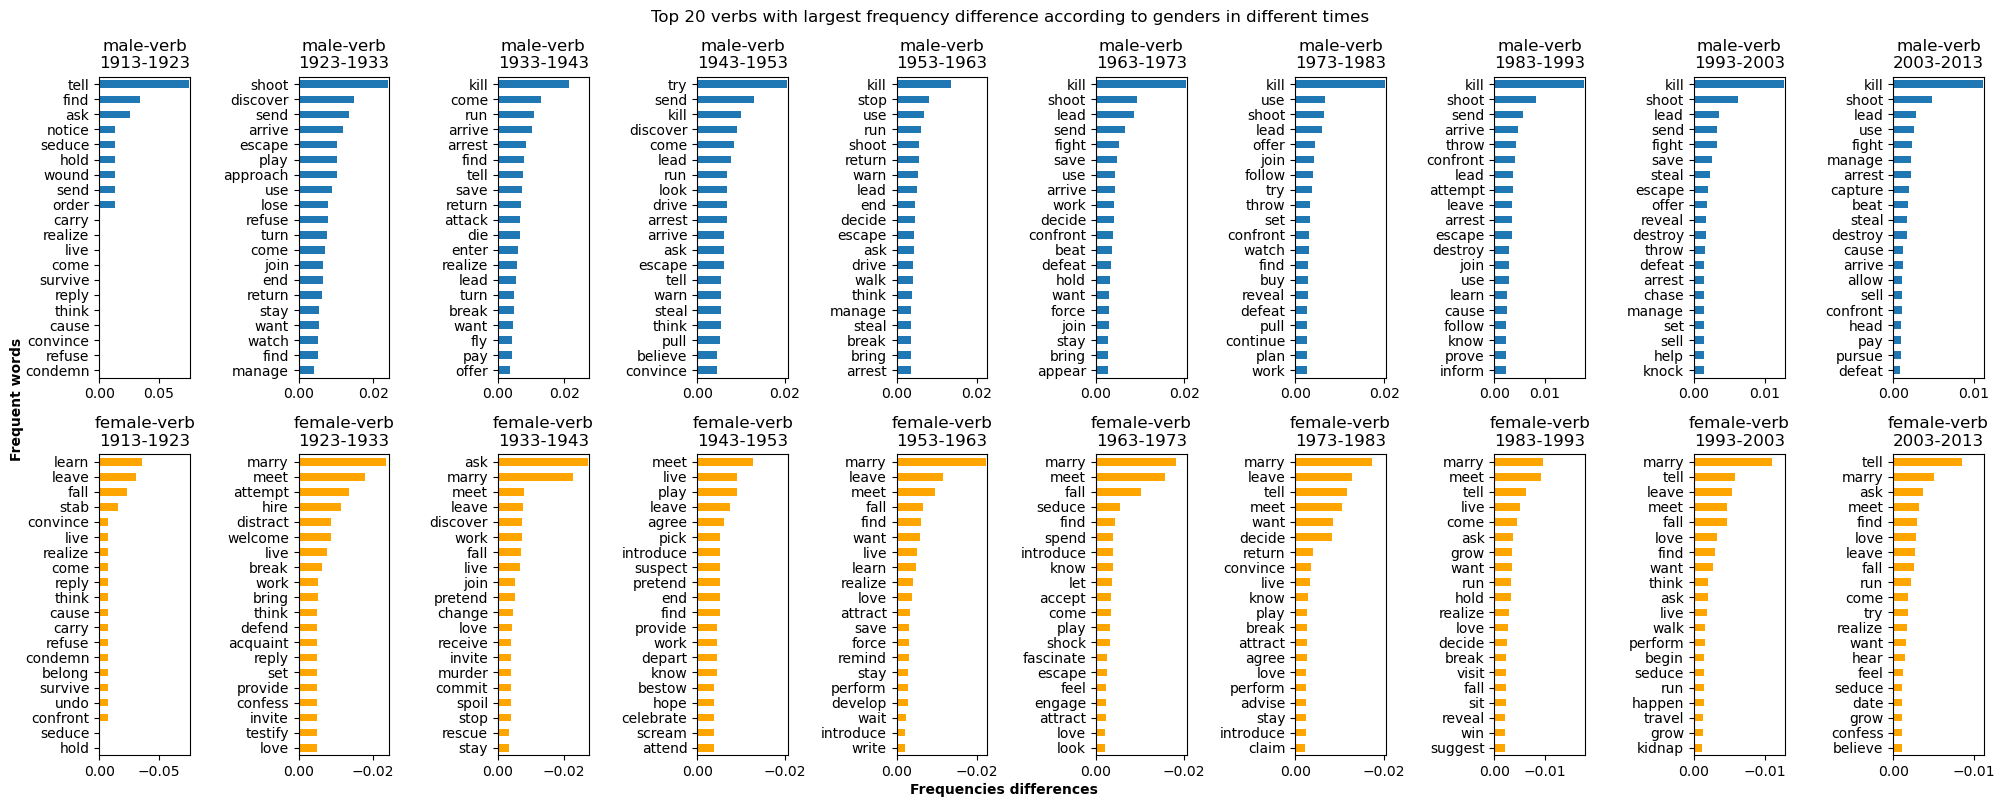

In [36]:
fig, axes = plt.subplots(2, 10, figsize=(20, 8))
axes = axes.ravel()
fig.suptitle(
    "Top 20 verbs with largest frequency difference according to genders in different times"
)

for idx, time_span in enumerate(time_spans):
    word_type = "verb"
    male_words = diff_dict_with_time[time_span][word_type].freq_diff.sort_values()[-20:]
    female_words = diff_dict_with_time[time_span][word_type].freq_diff.sort_values(ascending=False)[-20:]
    ax1 = male_words.plot.barh(
        ax=axes[idx], legend=False, title="male-{}\n{}-{}".format(word_type, round(time_span.left), round(time_span.right))
    )
    ax1.set_xlim(0.000, max(abs(male_words).max(), abs(female_words).max())*1.01)
    ax2 = female_words.plot.barh(
        ax=axes[idx + 10],
        color="orange",
        legend=False,
        title="female-{}\n{}-{}".format(word_type, round(time_span.left), round(time_span.right)),
    )
    ax2.set_xlim(0.000, -max(abs(male_words).max(), abs(female_words).max())*1.01)

fig.text(0.45, 0, "Frequencies differences", weight="bold")
fig.text(0, 0.42, "Frequent words", rotation=90, weight="bold")
plt.tight_layout()
plt.show()

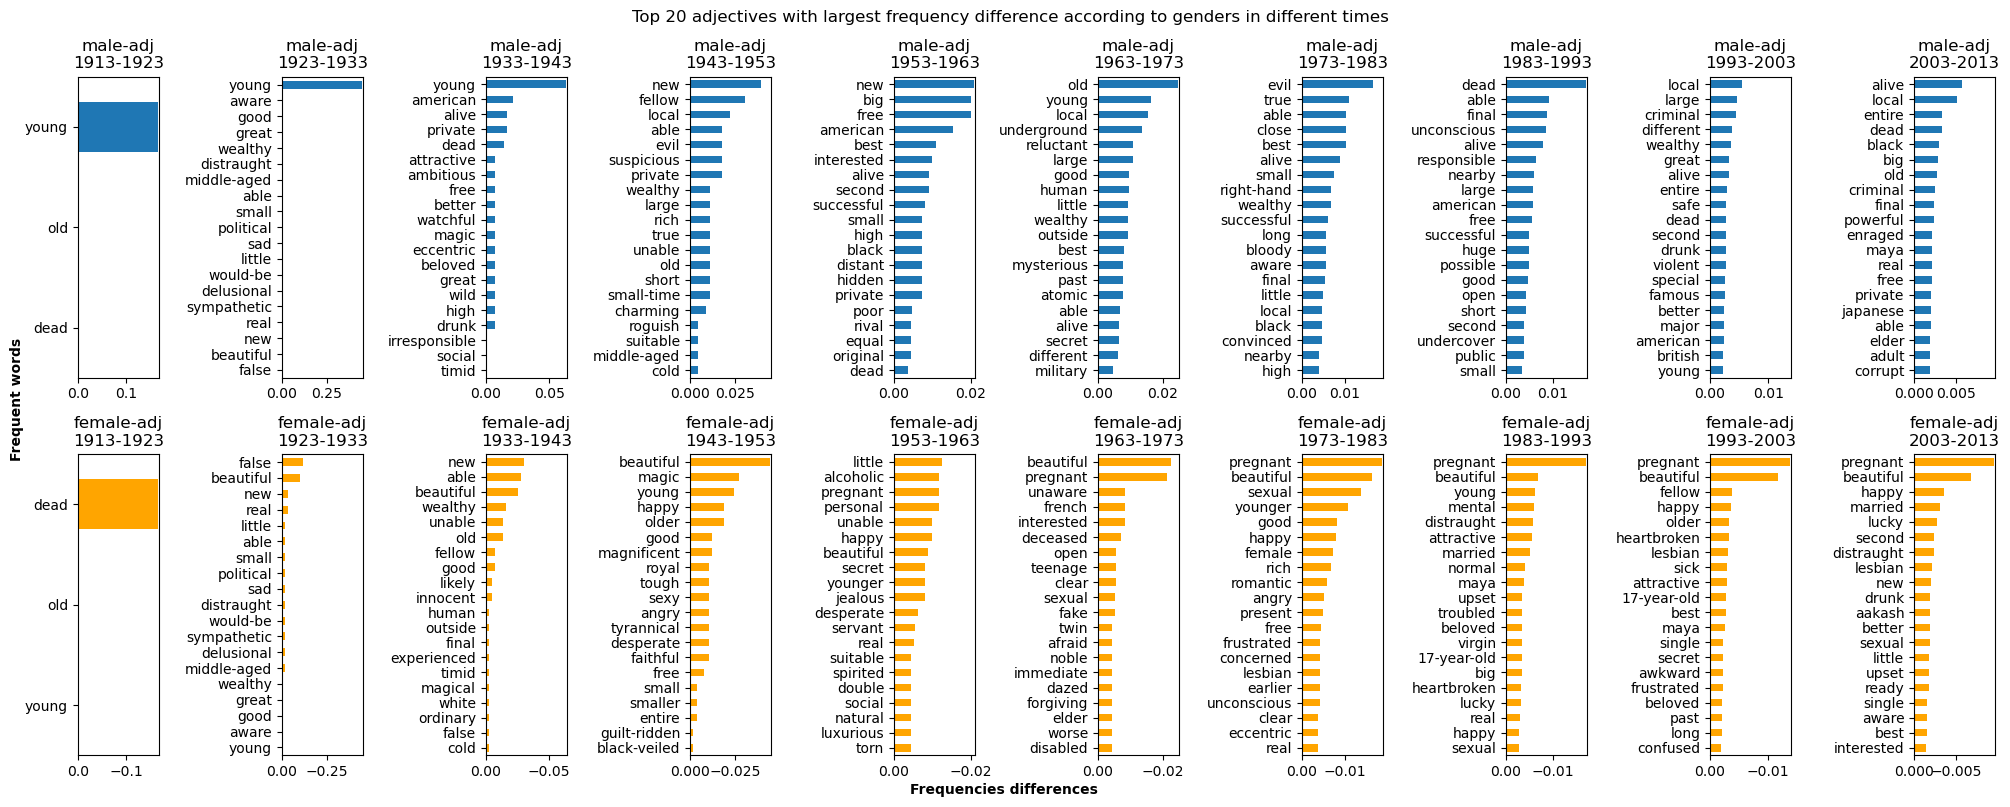

In [37]:
fig, axes = plt.subplots(2, 10, figsize=(20, 8))
axes = axes.ravel()
fig.suptitle(
    "Top 20 adjectives with largest frequency difference according to genders in different times"
)

for idx, time_span in enumerate(time_spans):
    word_type = "adj"
    male_words = diff_dict_with_time[time_span][word_type].freq_diff.sort_values()[-20:]
    female_words = diff_dict_with_time[time_span][word_type].freq_diff.sort_values(ascending=False)[-20:]
    ax1 = male_words.plot.barh(
        ax=axes[idx], legend=False, title="male-{}\n{}-{}".format(word_type, round(time_span.left), round(time_span.right))
    )
    ax1.set_xlim(0.000, max(abs(male_words).max(), abs(female_words).max())*1.01)
    ax2 = female_words.plot.barh(
        ax=axes[idx + 10],
        color="orange",
        legend=False,
        title="female-{}\n{}-{}".format(word_type, round(time_span.left), round(time_span.right)),
    )
    ax2.set_xlim(0.000, -max(abs(male_words).max(), abs(female_words).max())*1.01)

fig.text(0.45, 0, "Frequencies differences", weight="bold")
fig.text(0, 0.42, "Frequent words", rotation=90, weight="bold")
plt.tight_layout()
plt.show()

No clue on visualization and analysis...

### Quantitative

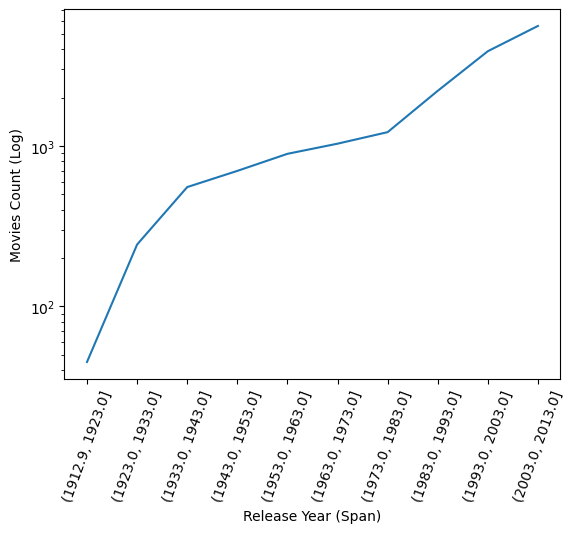

In [38]:
time_df = pd.DataFrame({
    'x': np.arange(10),
    'y': tmp.groupby("release_date_cat").count()["wikipedia_id"].values,
})
ax = sns.lineplot(
    data=time_df,
    x="x",
    y="y",
)
ax.set_yscale("log")
ax.set_xticks(np.arange(10))
ax.set_xticklabels(tmp.groupby("release_date_cat").count()["wikipedia_id"].index, rotation=70)
plt.xlabel("Release Year (Span)")
plt.ylabel("Movies Count (Log)")
plt.show()

The number of movies in the first decade is too small and the result may be unstable. Thus we disgard the first ten years.

In [39]:
df_reg = pd.DataFrame({
    'x': x[1:],
    'y': y[1:],
    'time_span': time[1:]
})
model = smf.ols(formula='y ~ x', data=df_reg)
np.random.seed(2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     16.21
Date:                Mon, 19 Dec 2022   Prob (F-statistic):            0.00502
Time:                        18:28:45   Log-Likelihood:                 19.462
No. Observations:                   9   AIC:                            -34.92
Df Residuals:                       7   BIC:                            -34.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2702      0.027     10.153      0.0

/home/fyy/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


We see a negative trend and it is significant.

In [40]:
last_span = time_spans[-1]

In [41]:
stats.chisquare(diff_dict_with_time[last_span]["verb"].sort_index().count_m, diff_dict_with_time[last_span]["verb"].sort_index().count_m.sum()*diff_dict_with_time[last_span]["verb"].sort_index().freq_f)

Power_divergenceResult(statistic=10043.382514619308, pvalue=0.0)

In [42]:
stats.chisquare(diff_dict_with_time[last_span]["verb"].sort_index().count_f, diff_dict_with_time[last_span]["verb"].sort_index().count_f.sum()*diff_dict_with_time[last_span]["verb"].sort_index().freq_m)

Power_divergenceResult(statistic=4660.925534367175, pvalue=4.83837663678155e-309)

In [43]:
stats.chisquare(diff_dict_with_time[last_span]["adj"].sort_index().count_m, diff_dict_with_time[last_span]["adj"].sort_index().count_m.sum()*diff_dict_with_time[last_span]["adj"].sort_index().freq_f)

Power_divergenceResult(statistic=4131.370372833231, pvalue=0.0)

In [44]:
stats.chisquare(diff_dict_with_time[last_span]["adj"].sort_index().count_f, diff_dict_with_time[last_span]["adj"].sort_index().count_f.sum()*diff_dict_with_time[last_span]["adj"].sort_index().freq_m)

Power_divergenceResult(statistic=2913.6626047304153, pvalue=9.322588446103035e-141)

There's still difference in word distributions between male and female today...

## Different Genre

In [45]:
genres_count = Counter(movies_plots_filtered.genres.sum())

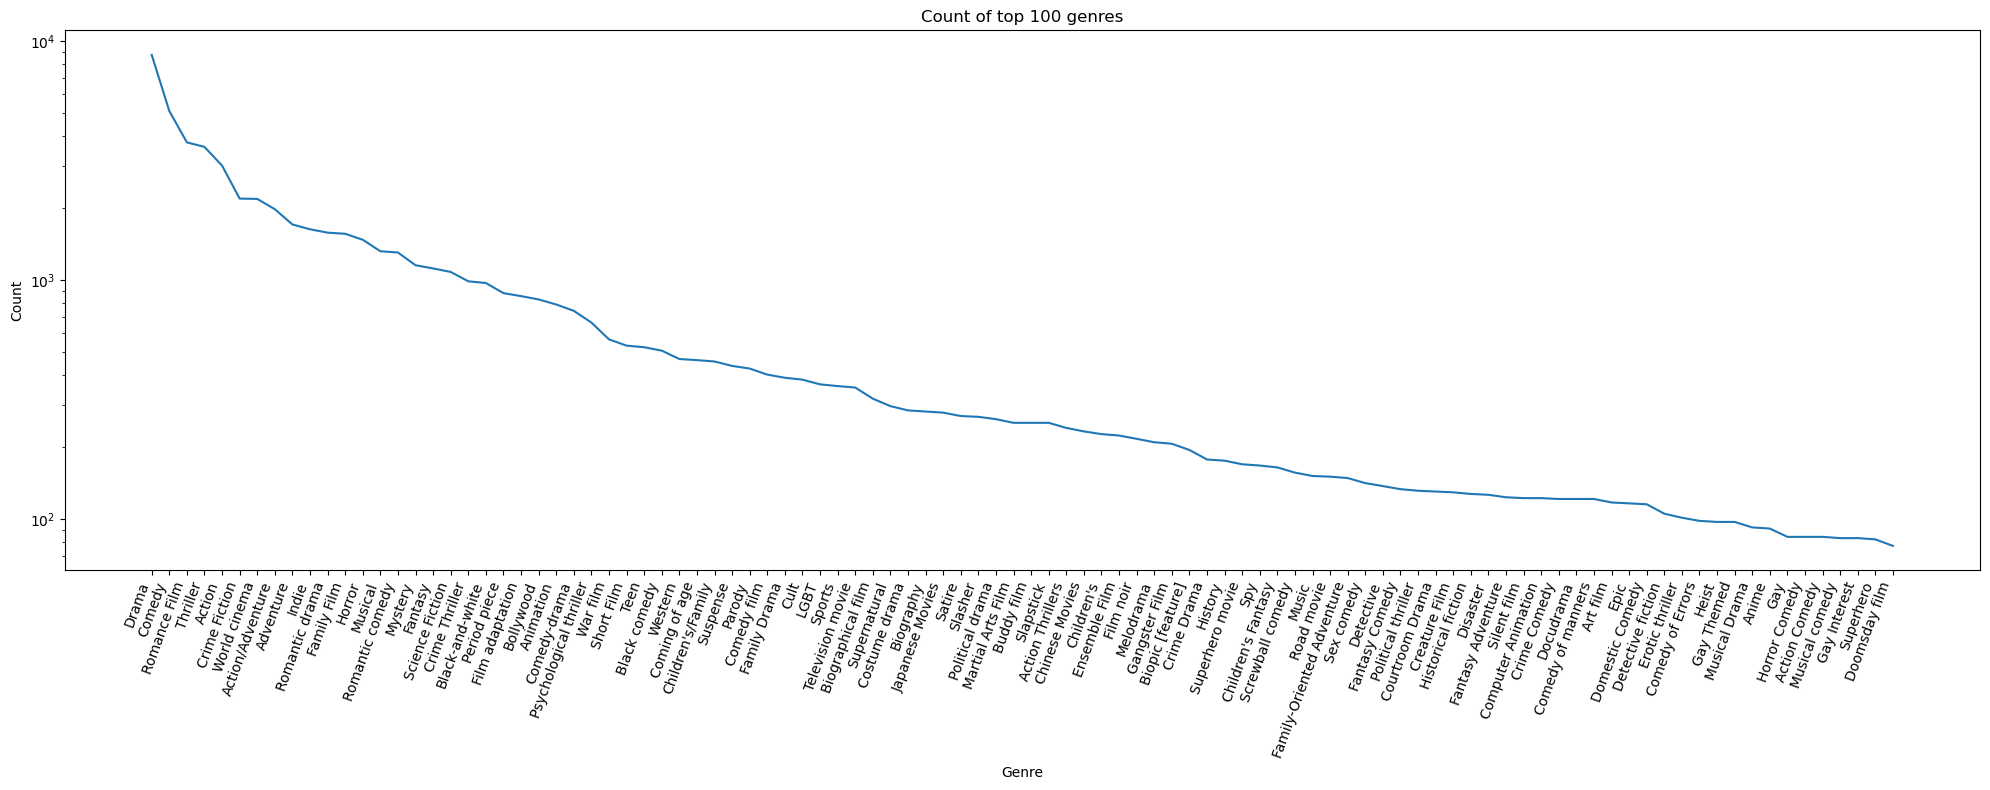

In [46]:
genres_distribution = pd.DataFrame.from_dict(genres_count, orient="index", columns=["count"]).sort_values(by="count", ascending=False)
ax = genres_distribution.iloc[:100].plot(xticks = np.arange(100), rot=70, logy=True, legend=False, figsize=(20, 8))
plt.xticks(ha="right")
plt.ylabel("Count")
plt.xlabel("Genre")
plt.title("Count of top 100 genres")
plt.tight_layout()
plt.show()

We only count the top 100 genres and it is long-tailed. Besides, the genre type has some overlaps (Romance film and Romance drama). So we just choose 10 main genres: Action, Adventure, Comedy, Drama, Horror, Romance Film, Science Fiction, Fantasy, Thriller, Family Film.

In [47]:
def is_genre(genre_list, genre="Drama"):
    return genre in genre_list


tmp = movies_plots_filtered.copy()

if not os.path.exists(gender_dict_with_genre_path):
    gender_dict_with_genre = {}
    for genre in "Action, Adventure, Comedy, Drama, Horror, Romance Film, Science Fiction, Fantasy, Thriller, Family Film".split(", "):
        group = tmp[tmp.genres.apply(lambda f: is_genre(f, genre))==True]
        gen_dict = {
            "M": {"all": {}, "noun": {}, "verb": {}, "adj": {}},
            "F": {"all": {}, "noun": {}, "verb": {}, "adj": {}},
        }
        # compute the word frequency every ten years
        gender_dict_with_genre[genre] = extract_word_frequency(group, gen_dict, pos_mapping, summary_path, window_size=window_size)

    # create a binary pickle file
    with open(gender_dict_with_genre_path, "wb") as f:
        # write the python object (dict) to pickle file
        pickle.dump(gender_dict_with_genre, f)

else:
    with open(gender_dict_with_genre_path, "rb") as f:
        gender_dict_with_genre = pickle.load(f)

In [48]:
for genre, gen_dict in gender_dict_with_genre.items():
    for gender, inner_dict in gen_dict.items():
        for word_type, freq_dict in inner_dict.items():
            for stopword in spacy_stopwords:
                    freq_dict.pop(stopword.lower(), None)

In [49]:
diff_dict_with_genre = {}
male_dict_with_genre = {}
female_dict_with_genre = {}

for genre, gen_dict in gender_dict_with_genre.items():
    male_dict_with_genre[genre] = {}
    female_dict_with_genre[genre] = {}
    diff_dict_with_genre[genre] = {}
    for idx, word_type in enumerate(["all", "noun", "verb", "adj"]):
        male_words = pd.DataFrame.from_dict(
            gen_dict["M"][word_type], orient="index", columns=["count"]
        ).sort_values(by=["count"])
        male_dict_with_genre[genre][word_type] = male_words

        female_words = pd.DataFrame.from_dict(
            gen_dict["F"][word_type], orient="index", columns=["count"]
        ).sort_values(by=["count"])
        female_dict_with_genre[genre][word_type] = female_words

        diff_words = pd.concat([male_words, female_words], axis=1).dropna()
        diff_words.columns = ["count_m", "count_f"]
        diff_words.fillna(0, inplace=True)
        diff_words["freq_m"] = diff_words["count_m"] / diff_words["count_m"].sum()
        diff_words["freq_f"] = diff_words["count_f"] / diff_words["count_f"].sum()
        diff_words["freq_diff"] = diff_words.freq_m - diff_words.freq_f
        diff_dict_with_genre[genre][word_type] = diff_words

In [50]:
genres = list(gender_dict_with_genre.keys())

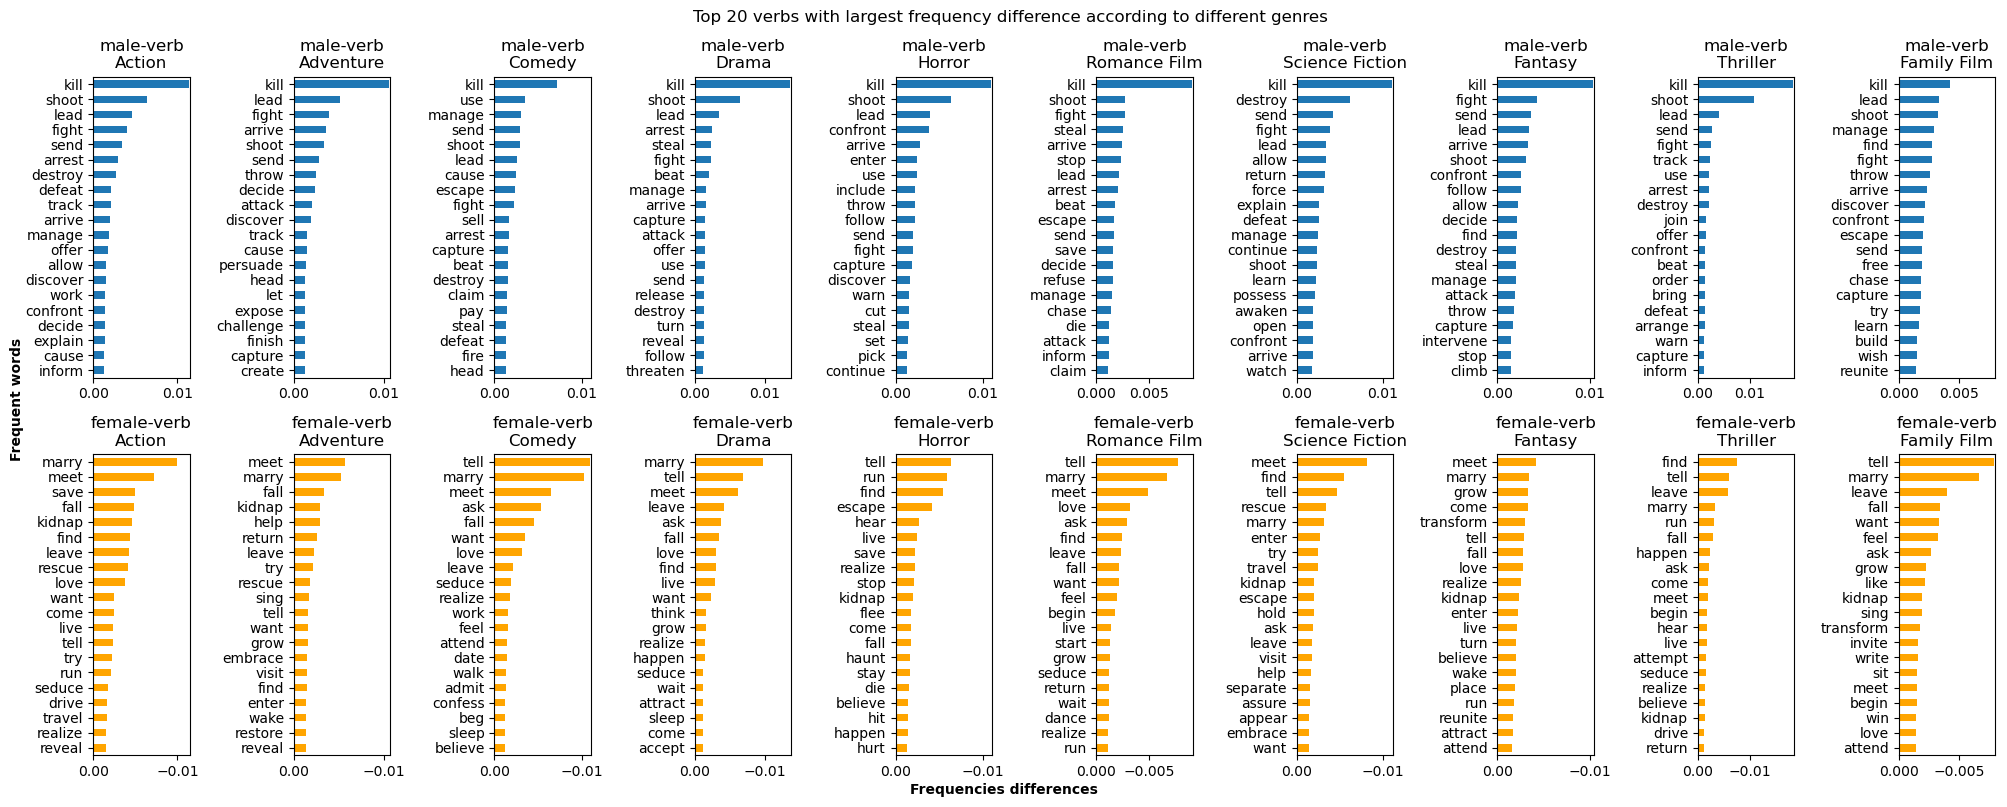

In [51]:
fig, axes = plt.subplots(2, 10, figsize=(20, 8))
axes = axes.ravel()
fig.suptitle(
    "Top 20 verbs with largest frequency difference according to different genres"
)

for idx, genre in enumerate(genres):
    word_type = "verb"
    male_words = diff_dict_with_genre[genre][word_type].freq_diff.sort_values()[-20:]
    female_words = diff_dict_with_genre[genre][word_type].freq_diff.sort_values(ascending=False)[-20:]
    ax1 = male_words.plot.barh(
        ax=axes[idx], legend=False, title="male-{}\n{}".format(word_type, genre)
    )
    ax1.set_xlim(0.000, max(abs(male_words).max(), abs(female_words).max())*1.01)
    ax2 = female_words.plot.barh(
        ax=axes[idx + 10],
        color="orange",
        legend=False,
        title="female-{}\n{}".format(word_type, genre),
    )
    ax2.set_xlim(0.000, -max(abs(male_words).max(), abs(female_words).max())*1.01)

fig.text(0.45, 0, "Frequencies differences", weight="bold")
fig.text(0, 0.42, "Frequent words", rotation=90, weight="bold")
plt.tight_layout()
plt.show()

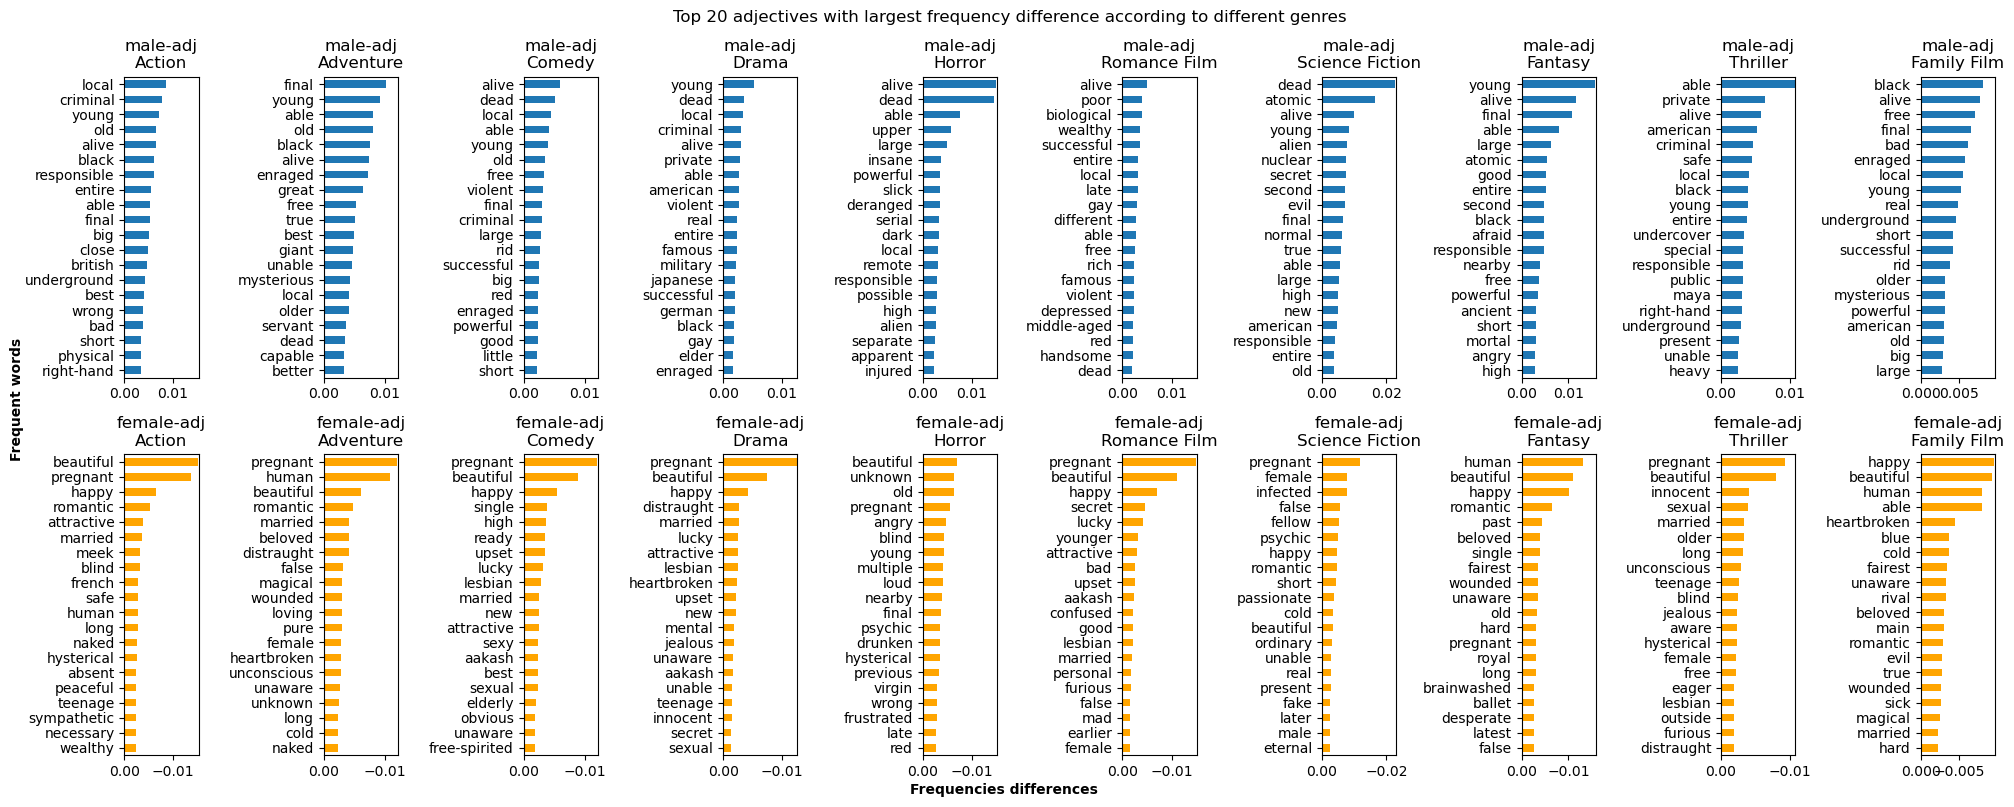

In [52]:
fig, axes = plt.subplots(2, 10, figsize=(20, 8))
axes = axes.ravel()
fig.suptitle(
    "Top 20 adjectives with largest frequency difference according to different genres"
)

for idx, genre in enumerate(genres):
    word_type = "adj"
    male_words = diff_dict_with_genre[genre][word_type].freq_diff.sort_values()[-20:]
    female_words = diff_dict_with_genre[genre][word_type].freq_diff.sort_values(ascending=False)[-20:]
    ax1 = male_words.plot.barh(
        ax=axes[idx], legend=False, title="male-{}\n{}".format(word_type, genre)
    )
    ax1.set_xlim(0.000, max(abs(male_words).max(), abs(female_words).max())*1.01)
    ax2 = female_words.plot.barh(
        ax=axes[idx + 10],
        color="orange",
        legend=False,
        title="female-{}\n{}".format(word_type, genre),
    )
    ax2.set_xlim(0.000, -max(abs(male_words).max(), abs(female_words).max())*1.01)

fig.text(0.45, 0, "Frequencies differences", weight="bold")
fig.text(0, 0.42, "Frequent words", rotation=90, weight="bold")
plt.tight_layout()
plt.show()

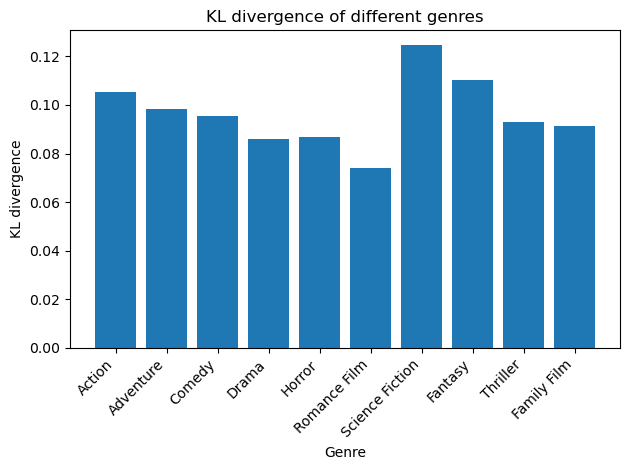

In [58]:
divergences_KL = []

for genre, diff_dict in diff_dict_with_genre.items():
    divergences_KL.append(KL(diff_dict["verb"].sort_index().freq_m, diff_dict["verb"].sort_index().freq_f))

plt.bar(genres, divergences_KL)
plt.xticks(ha="right", rotation=45)
plt.ylabel("KL divergence")
plt.xlabel("Genre")
plt.title("KL divergence of different genres")
plt.tight_layout()
plt.show()

In [59]:
least_div_genre = "Romance Film"

stats.chisquare(diff_dict_with_genre[least_div_genre]["verb"].sort_index().count_m, diff_dict_with_genre[least_div_genre]["verb"].sort_index().count_m.sum()*diff_dict_with_genre[least_div_genre]["verb"].sort_index().freq_f)

Power_divergenceResult(statistic=4073.315372432018, pvalue=0.0)

In [60]:
stats.chisquare(diff_dict_with_genre[least_div_genre]["verb"].sort_index().count_f, diff_dict_with_genre[least_div_genre]["verb"].sort_index().count_f.sum()*diff_dict_with_genre[least_div_genre]["verb"].sort_index().freq_m)

Power_divergenceResult(statistic=2729.4106661805436, pvalue=4.397949582114112e-136)